In [1]:
%load_ext autoreload
%autoreload 2

import torch, click, numpy as np

import swyft
from utils import *
from plot import *

from tqdm import tqdm



DEVICE = 'cuda'


from torch import tensor

imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower') #left, right, bottom, top

import matplotlib.colors
from IPython.display import HTML
import matplotlib.animation as animation
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['axes.facecolor']='white'


In [344]:
m = 1
nsub = 5
nsim = 50_000

nmbins = 3

lr = 1e-3
factor = 1e-1
patience = 5

system_name = "ngc4414"

In [345]:
# Set utilities
sim_name, sim_path = get_sim_path(m, nsub, nsim, system_name)
store = swyft.Store.load(path=sim_path)
print(f'Store has {len(store)} simulations.')

config = get_config(system_name, str(nsub), str(m))

prior, n_pars, lows, highs = get_prior(config)
L = config.kwargs["defs"]["nx"]
print(f'Image has L = {L}.')

# dataset = swyft.Dataset(nsim, prior, store)#, simhook = noise)

Store _M_m1_nsub5_nsim50000 exists!
Loading existing store.
Store has 49701 simulations.
Image has L = 40.


In [346]:
# Load network
mre_name, mre_path = get_mre_path(sim_name, nmbins, lr, factor, patience)
print(f'Loading {mre_name}!')

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

marginal_indices, _ = swyft.utils.get_corner_marginal_indices(n_pars)

network = get_custom_marginal_classifier(
    observation_transform = CustomObservationTransform('image', {'image': (L, L)}),
    marginal_indices = marginal_indices,
    L = L,
    nmbins = nmbins, 
    lows = lows,
    highs = highs,
    marginal_classifier = CustomMarginalClassifier,
)

mre = swyft.MarginalRatioEstimator.load(
    network=network,
    device=DEVICE,
    filename=mre_path,
)

torch.set_default_tensor_type(torch.FloatTensor)

Loading UNet_M_m1_nsub5_nsim50000_nmbins3_lr-3.0_fac-1.0_pat5.pt!


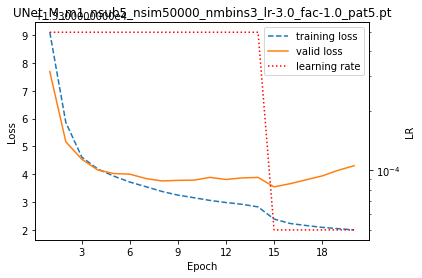

In [347]:
plot_losses(mre, title = mre_name)#, save_name = mre_name)

In [348]:
def get_coords(nmbins, L):
    grid = torch.linspace(lows[0], highs[0], L+1)[:-1]
    x, y = torch.meshgrid(grid, grid, indexing = 'xy')
    m = torch.logspace(lows[-1], highs[-1], 2*nmbins+1)
    m_centers, m_edges = m[1::2], m[0::2]
    ms = [torch.full((L*L,), m_i) for m_i in m_centers]

    coord_empty = torch.tensor((), device = DEVICE, dtype = torch.float).reshape(1, -1)
    
    coord_full = []
    for m in ms:
        coord = torch.transpose(torch.stack((x.flatten(), y.flatten(), m)), 0, 1).reshape(1, -1).to(DEVICE, dtype = torch.float)
        coord_full.append(coord)

    coords = [coord_empty] + coord_full
    return coords, coord_empty, coord_full, m_centers, m_edges 

def get_obs(store, i = -1):
    obs0_i = np.random.randint(0, len(store)) if i == -1 else i
    print(f'i = {obs0_i}')
    
    obs0 = store[obs0_i][0]
    v0 = store[obs0_i][1]

    obs0['image'] = tensor(obs0['image']).unsqueeze(0).to(DEVICE, dtype = torch.float)
    v0 = tensor(v0).unsqueeze(0).to(DEVICE)
    
    return obs0, v0, obs0_i

coords, coord_empty, coord_full, m_centers, m_edges = get_coords(nmbins, L)

mbins = np.linspace(lows[2], highs[2], nmbins + 1)
title_mbins = [f'mass {mbins[i]} - {mbins[i+1]}' for i in range(nmbins)]
title_halos = [f'{j} {k}' for j in ['no halo', 'halo'] for k in title_mbins ]
titles = [f'{i} {j}' for i in ['target', 'ratio '] for j in title_halos ]


In [349]:
prior = nsub/(L*L)/nmbins
prior0 = 1 - prior
prior1 = prior
priors = np.repeat(np.array([prior0, prior1]), nmbins) 

print(f'prior no halo \t{prior0}\npario halo \t{prior1}')

prior no halo 	0.9989583333333333
pario halo 	0.0010416666666666667


In [374]:
def get_pred(obs0_i = -1):
    
    # Get observation and targets
    obs0, v0, obs0_i = get_obs(store, obs0_i)
    targets = mre.network.parameter_transform(v0).squeeze()

    # Get logratios
    logratios = np.zeros((nmbins*2, L, L))
    logratios[:nmbins] = mre.network(obs0, coord_empty).view(nmbins*2, L, L)[:nmbins]
    logratios[nmbins:] = torch.stack([
        mre.network(obs0, coord).view(nmbins*2, L, L)[i+nmbins] for i, coord in enumerate(coord_full)
    ])
        
    # Posterior 
    posts = np.exp(logratios) * (priors)[:, np.newaxis, np.newaxis]
    posts_sum = np.sum(posts.reshape(2, nmbins, L, L).transpose([1,0,2,3]), axis = 1)
    posts_sum = np.tile(posts_sum, (2,1,1))
    posts_norm = posts / posts_sum
    
    # Target coordinates
    x, y, m = v0.view(-1, 3).T.numpy()
    m_i = np.where(targets[nmbins:] == 1)[0]
    target_coords = np.array((m_i, x, y)).T
    target_coords_alt = np.array((m_i, y,x)).T
    
    scatter = np.array([np.array(np.where(targets[nmbins:] == 1))[i] for i in [2, 1, 0]])
    scatter_alt= np.array([np.array(np.where(targets[nmbins:] == 1))[i] for i in [1,2, 0]])
    
    return posts_norm[nmbins:], target_coords, target_coords_alt, scatter, scatter_alt, obs0_i, obs0, [x,y,m], posts, targets



## Final results

In [371]:
def find_nrows(l):
    a = np.array([(i, l/i, i+l/i) for i in range(1, l) if (l/i).is_integer()])
    i_min = np.argmin(a[:, -1], axis = 0)
    return int(a[i_min].min())

i = 30627
37.37741662179687


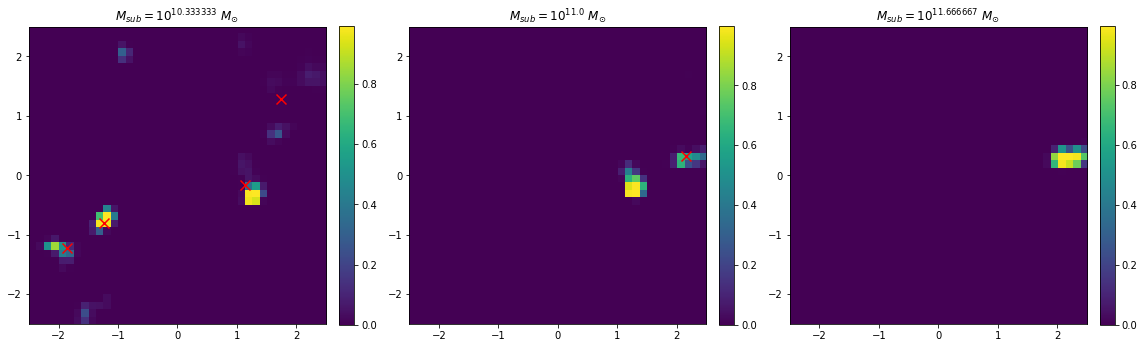

In [451]:
for _ in range(1):
    post, target_coords, target_coords_alt, scatter, scatter_alt, obs0_i, obs0, [x,y,m], posts_all, targets = get_pred(30627)
    
    print(np.sum(post))
    
    nrows = find_nrows(len(post))
    titles = [rf'$M_{{sub}} = 10^{ {m} }\ M_{{\odot}}$' for m in np.log10(m_centers.numpy())]

    log = False
    plt_imshow(post, nrows, target_coords = target_coords, cbar = True, titles = titles, tl = True, ylog = log, **imkwargs)
#     plt_imshow(post, nrows, target_coords = target_coords_alt, cbar = True, titles = titles, tl = True, ylog = log, **imkwargs)


In [87]:
# # Get observation and targets
# obs0, v0, obs0_i = get_obs(store, obs0_i)
# targets = mre.network.parameter_transform(v0).squeeze()

# # Get logratios
# logratios = np.zeros((nmbins*2, L, L))
# logratios[:nmbins] = mre.network(obs0, coord_empty).view(nmbins*2, L, L)[:nmbins]
# logratios[nmbins:] = torch.stack([
#     mre.network(obs0, coord).view(nmbins*2, L, L)[i+nmbins] for i, coord in enumerate(coord_full)
# ])

# # Posterior 
# posts = np.exp(logratios) * (priors)[:, np.newaxis, np.newaxis]
# posts_sum = np.sum(posts.reshape(2, nmbins, L, L).transpose([1,0,2,3]), axis = 1)
# posts_sum = np.tile(posts_sum, (2,1,1))
# posts_norm = posts / posts_sum

# # Target coordinates
# x, y, m = v0.view(-1, 3).T.numpy()
# m_i = np.where(targets[nmbins:] == 1)[0]
# target_coords = np.array((m_i, x, y)).T

# scatter = np.array([np.array(np.where(targets[nmbins:] == 1))[i] for i in [1, 2, 0]])

i = 37381


In [381]:
scatter

array([[ 5, 10, 29, 33, 37],
       [10, 13, 18, 30, 22],
       [ 0,  0,  0,  0,  1]])

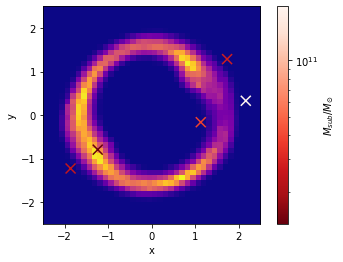

In [383]:
fig, ax = plt.subplots()

ax.imshow(obs0['image'].squeeze(), cmap = 'plasma', **imkwargs)
im = ax.scatter(x, y, marker = 'x', s = 100, c = m, cmap = 'Reds_r', norm=matplotlib.colors.LogNorm())

cbar = plt.colorbar(im, ax = ax)
cbar.ax.set_ylabel(r'$M_{sub}/M_{\odot}$')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

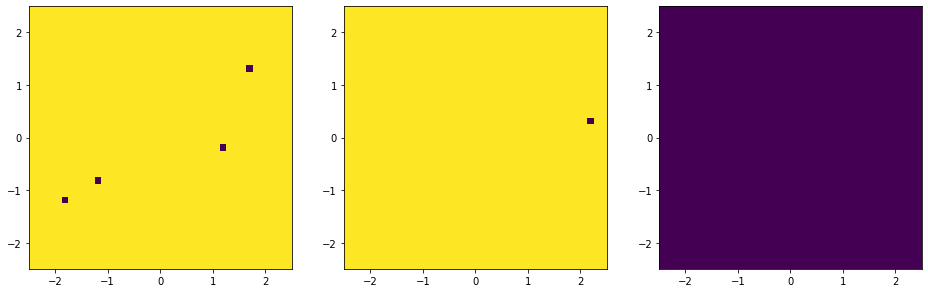

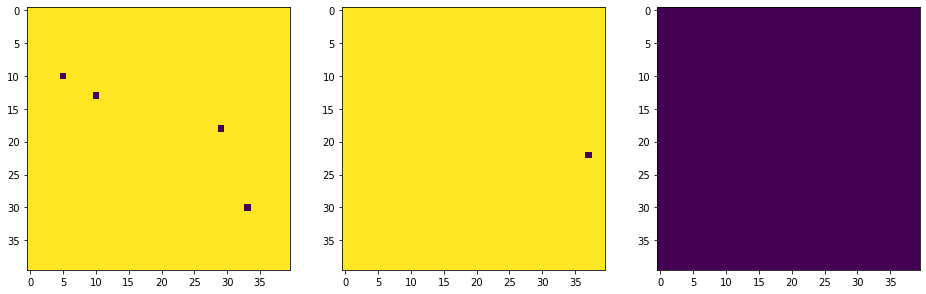

In [386]:
plt_imshow(targets[:nmbins], **imkwargs)
plt_imshow(targets[:nmbins])

# Lava lamp

In [363]:
def normalize(d):
    d -= d.min()
    d /= d.max()
    return d

def cuboid_data(center, size=(1,1,1)):
    # code taken from
    # http://stackoverflow.com/questions/30715083/python-plotting-a-wireframe-3d-cuboid?noredirect=1&lq=1
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(center, size)]
    # get the length, width, and height
    l, w, h = size
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],                # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],                # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],                # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]                # x coordinate of points in inside surface
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],                # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],                # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],                        # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]    # y coordinate of points in inside surface
    z = [[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]                # z coordinate of points in inside surface
    return np.array((x, y, z))

def plotCubeAt(pos=(0,0,0), c="b", alpha=1, ax=None):
    # Plotting N cube elements at position pos
    if ax !=None:
        X, Y, Z = cuboid_data( (pos[0],pos[1],pos[2]) )
        ax.plot_surface(X, Y, Z, color=c, rstride=1, cstride=1, alpha=alpha)

def plotMatrix(ax, x, y, z, threshold, data, cmap=plt.cm.viridis, cax=None, falpha=1):
    # plot a Matrix 
    norm = matplotlib.colors.Normalize(vmin=data.min(), vmax=data.max())
    colors = lambda i,j,k : matplotlib.cm.ScalarMappable(norm=norm,cmap = cmap).to_rgba(data[i,j,k]) 
    alphas = lambda i,j,k : normalize(data)[i,j,k] 
    for i, xi in enumerate(x):
        for j, yi in enumerate(y):
            for k, zi, in enumerate(z):
                if data[i,j,k] > threshold:
                    plotCubeAt(pos=(xi, yi, zi), c=colors(i,j,k), alpha=alphas(i,j,k), ax=ax)

In [441]:
def cuboid_data(x1, x2, y1, y2, z1, z2):
    # code taken from
    # http://stackoverflow.com/questions/30715083/python-plotting-a-wireframe-3d-cuboid?noredirect=1&lq=1
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
#     o = [a - b / 2 for a, b in zip(center, size)]
    # get the length, width, and height
#     l, w, h = size
    x = [[x1, x2, x2, x1, x1],                # x coordinate of points in bottom surface
         [x1, x2, x2, x1, x1],                # x coordinate of points in upper surface
         [x1, x2, x2, x1, x1],                # x coordinate of points in outside surface
         [x1, x2, x2, x1, x1]]                # x coordinate of points in inside surface
    y = [[y1, y1, y2, y2, y1],                # y coordinate of points in bottom surface
         [y1, y1, y2, y2, y1],                # y coordinate of points in upper surface
         [y1, y1, y1, y1, y1],                # y coordinate of points in outside surface
         [y2, y2, y2, y2, y2]]                # y coordinate of points in inside surface
    z = [[z1, z1, z1, z1, z1],                # z coordinate of points in bottom surface
         [z2, z2, z2, z2, z2],                # z coordinate of points in upper surface
         [z1, z1, z2, z2, z1],                # z coordinate of points in outside surface
         [z1, z1, z2, z2, z1]]                # z coordinate of points in inside surface
    return np.array((x, y, z))

def plotCubeAt(x1, x2, y1, y2, z1, z2, c="b", alpha=1, ax=None):
    # Plotting N cube elements at position pos
    if ax !=None:
        X, Y, Z = cuboid_data( x1, x2, y1, y2, z1, z2 )
#         print(np.log(z1), np.log(z2))
        ax.plot_surface(X, Y, Z, color=c, rstride=1, cstride=1, alpha=alpha)

def plotMatrix(ax, x, y, z, threshold, data, cmap=plt.cm.viridis, cax=None, falpha=1):
    # plot a Matrix 
    norm = matplotlib.colors.Normalize(vmin=data.min(), vmax=data.max())
    colors = lambda i,j,k : matplotlib.cm.ScalarMappable(norm=norm,cmap = cmap).to_rgba(data[i,j,k]) 
    alphas = lambda i,j,k : normalize(data)[i,j,k] 
    
    for i, xi in enumerate(range(p.shape[0])):
        for j, yi in enumerate(range(p.shape[1])):
            for k, zi, in enumerate(range(p.shape[2])):
                if data[i,j,k] > threshold:
                    plotCubeAt(x[i], x[i+1],
                               y[j], y[j+1],
                               z[k], z[k+1], 
                               c=colors(i,j,k), alpha=alphas(i,j,k), ax=ax)
#                 print(i, j, k)
    
#     for i, xi in enumerate(x):
#         for j, yi in enumerate(y):
#             for k, zi, in enumerate(z):
#                 if data[i,j,k] > threshold:
#                     plotCubeAt(pos=(xi, yi, zi), c=colors(i,j,k), alpha=alphas(i,j,k), ax=ax)

In [444]:
x_edges = np.linspace(-2.5, 2.5, L+1)
y_edges = np.linspace(-2.5, 2.5, L+1)
z_edges = np.log10(m_edges.numpy())

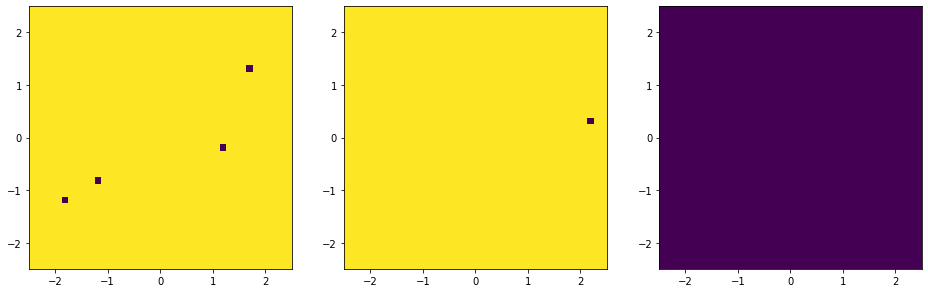

In [460]:
plt_imshow(targets[:nmbins], **imkwargs)
# plt_imshow(targets[:nmbins])

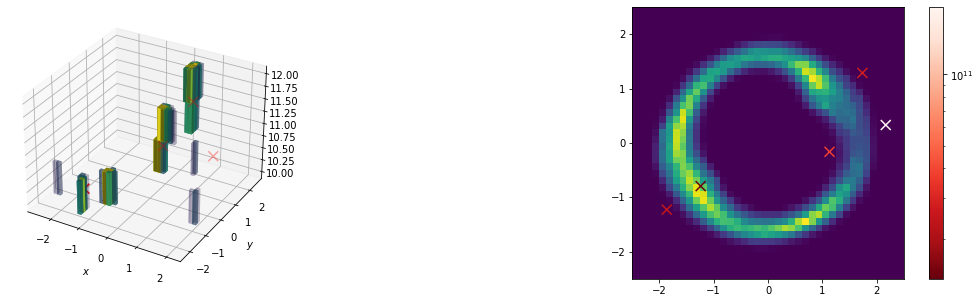

In [461]:
fig = plt.figure(figsize = (20,5))

n = 2

ax = fig.add_subplot(1, n, 1, projection='3d')
plotMatrix(ax, x_edges, y_edges, z_edges, 0.1, p)

ax.scatter(*(y,x,np.log10(m)), marker = 'x', color = 'red', s = 100)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

ax = fig.add_subplot(1, n, 2)
ax.imshow(obs0['image'].squeeze(), **imkwargs)
im = ax.scatter(*(np.array((x,y))), marker = 'x', s = 100, c = m, cmap = 'Reds_r', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar(im, ax = ax)

In [396]:
p.shape

(40, 40, 3)

In [171]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

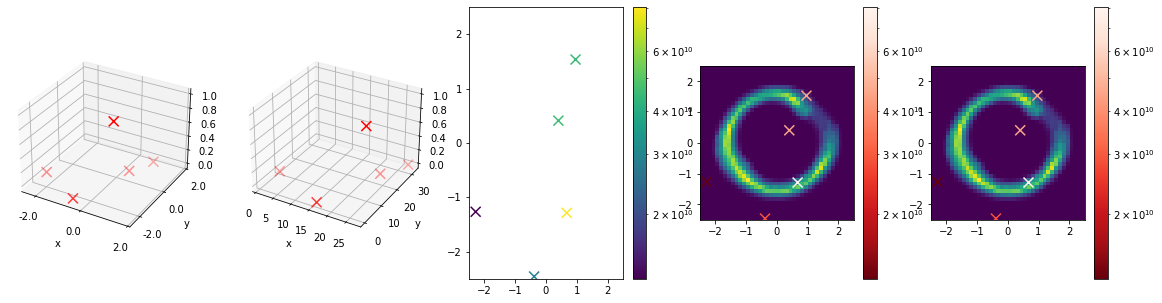

In [364]:
fig = plt.figure(figsize = (20, 5))
n = 5
ax = fig.add_subplot(1, n, 1, projection='3d')
ax.scatter(*scatter, marker = 'x', color = 'red', s = 100)
tickskip = 4
# ax.set_xticks(np.linspace(0, L)[1::tickskip])
ax.set_xticks(np.linspace(0, L, 11)[1::tickskip])
ax.set_yticks(np.linspace(0, L, 11)[1::tickskip])
ax.set_xticklabels(np.linspace(-2.5, 2.5, 11)[1::tickskip])
ax.set_yticklabels(np.linspace(-2.5, 2.5, 11)[1::tickskip])
# ax.set_zticks(z)
# ax.set_zticklabels(np.round(np.log10(m_centers.numpy()), 2))
ax.set_xlabel('x')
ax.set_ylabel('y')


ax = fig.add_subplot(1, n, 2, projection='3d')
ax.scatter(*scatter, marker = 'x', color = 'red', s = 100)
tickskip = 4
# ax.set_xticks(np.linspace(0, L, 11)[1::tickskip])
# ax.set_yticks(np.linspace(0, L, 11)[1::tickskip])
# ax.set_xticklabels(np.linspace(-2.5, 2.5, 11)[1::tickskip])
# ax.set_yticklabels(np.linspace(-2.5, 2.5, 11)[1::tickskip])
# # ax.set_zticks(z)
# # ax.set_zticklabels(np.round(np.log10(m_centers.numpy()), 2))
ax.set_xlabel('x')
ax.set_ylabel('y')


ax = fig.add_subplot(1, n, 3)
im = ax.scatter(x, y, marker = 'x', s = 100, c = m, norm=matplotlib.colors.LogNorm())
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
cbar = plt.colorbar(im, ax = ax)

ax = fig.add_subplot(1, n, 4)
ax.imshow(obs0['image'].squeeze(), **imkwargs)
im = ax.scatter(x, y, marker = 'x', s = 100, c = m, cmap = 'Reds_r', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar(im, ax = ax)

ax = fig.add_subplot(1, n, 5)
ax.imshow(obs0['image'].squeeze(), **imkwargs)
im = ax.scatter(*(np.array((x,y))), marker = 'x', s = 100, c = m, cmap = 'Reds_r', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar(im, ax = ax)

plt.show()

In [365]:
scatter, x, y

(array([[16,  1, 23, 27, 25],
        [ 0,  9, 23, 32,  9],
        [ 0,  0,  0,  0,  1]]),
 array([-2.28337668,  0.96120775, -0.38395911,  0.40423185,  0.67487806]),
 array([-1.26660414,  1.53384686, -2.45782927,  0.40943623, -1.28652461]))

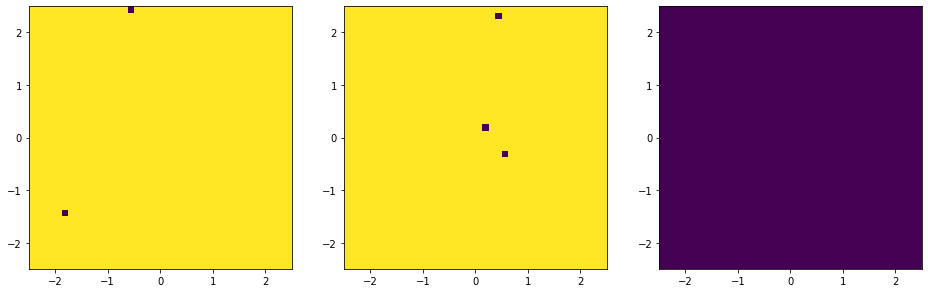

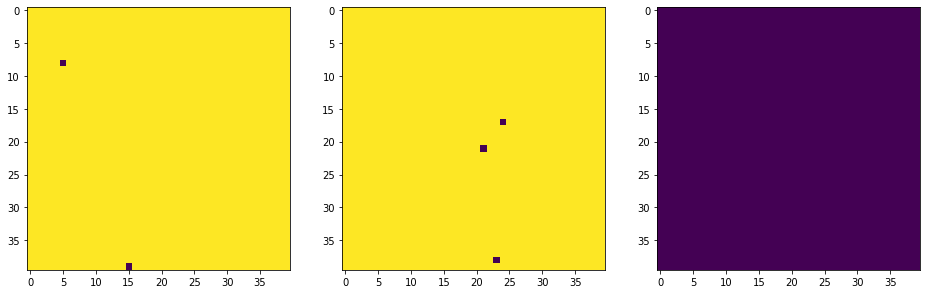

In [226]:
plt_imshow(targets[:nmbins], **imkwargs)
plt_imshow(targets[:nmbins])

In [ ]:
fig, ax = plt.subplots()

ax.imshow(obs0['image'].squeeze(), cmap = 'plasma', **imkwargs)
im = ax.scatter(x, y, marker = 'x', s = 100, c = m, cmap = 'Reds_r', norm=matplotlib.colors.LogNorm())

cbar = plt.colorbar(im, ax = ax)
cbar.ax.set_ylabel(r'$M_{sub}/M_{\odot}$')

plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [389]:
np.arange(-L, 0)

array([-40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28,
       -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15,
       -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,
        -1])

i = 43456


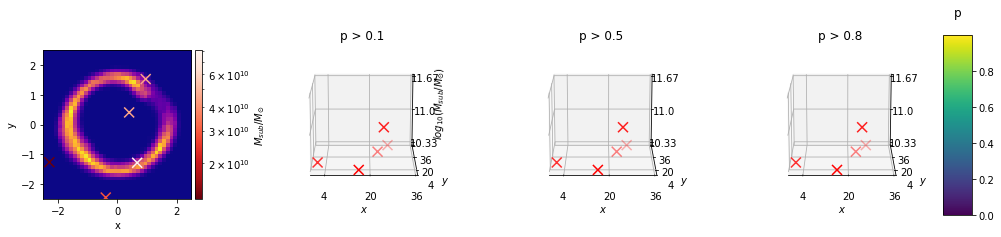

In [394]:
def lava_movie(obs0_i = -1, frames = 10, thresholds = [0.1, 0.5, 0.8]):
    post, _, _, scatter, scatter_alt, obs0_i, obs0, [x,y,m], _, targets = get_pred(obs0_i = obs0_i)
    

    fig = plt.figure(figsize = (20,5))
    
    ax = fig.add_subplot(1, len(thresholds)+2, 1)
    ax.imshow(obs0['image'].squeeze(), cmap = 'plasma', **imkwargs)
    im = ax.scatter(x, y, marker = 'x', s = 100, c = m, cmap = 'Reds_r', norm=matplotlib.colors.LogNorm())
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax = cax)
    cbar.ax.set_ylabel(r'$M_{sub}/M_{\odot}$')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    
    y = np.arange(-L, 0)
    x = np.arange(L) #np.linspace(0, 1, L)
    z = np.arange(len(m_centers)) #m_centers.numpy()
    p = np.transpose(post, [1,2,0])

    axs = ([])

    for i, threshold in enumerate(thresholds):
        ax = fig.add_subplot(1, len(thresholds)+2, i+2, projection='3d')
#         plotMatrix(ax, x, y, z, threshold, p)

        ax.scatter(*scatter, marker = 'x', color = 'red', s = 100)

        labelsize = 10
        ax.set_title(f'p > {threshold}')
        ax.set_xlabel(r'$x$', fontsize = labelsize)
        ax.set_ylabel(r'$y$', fontsize = labelsize)
        if i == 0: ax.set_zlabel(r'$log_{10}(M_{sub}/M_{\odot})$', fontsize = labelsize)

        tickskip = 4
        ax.set_xticks(np.linspace(0, L, 11)[1::tickskip])
        ax.set_yticks(np.linspace(0, L, 11)[1::tickskip])
#         ax.set_xticklabels(np.linspace(-2.5, 2.5, 11)[1::tickskip])
#         ax.set_yticklabels(np.linspace(-2.5, 2.5, 11)[1::tickskip])
        ax.set_zticks(z)
        ax.set_zticklabels(np.round(np.log10(m_centers.numpy()), 2))

        axs.append(ax)


    ax = fig.add_axes([0.75, 0.25, 0.02, 0.5])
    norm = matplotlib.colors.Normalize(vmin=p.min(), vmax=p.max())
    cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=plt.cm.viridis,
                                norm=norm,
                                orientation='vertical')  
    cbar.ax.set_title('p', pad = 19)

    fig.subplots_adjust(wspace=0.5)

    def animate(i):
        for ax in axs:
            ax.view_init(elev=15., azim=-90+i)
        return fig,

    ani = animation.FuncAnimation(fig, animate, #init_func=init,
                                   frames=frames, interval=200, blit=True)    
    
    return ani, obs0_i, targets
    
    
obs0_is = [12755, 10880, 6921]
obs0_is = [obs0_i]
obs0_is = [-1]
obs0_is = [43456]

for obs0_i in obs0_is:
    ani, obs0_i, targets = lava_movie(obs0_i = obs0_i, frames = 50, thresholds = [0.1, 0.5, 0.8])
#     ani.save(f'mp4s/{obs0_i}.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    # ani.save(f'gifs/{obs0_i}.gif')

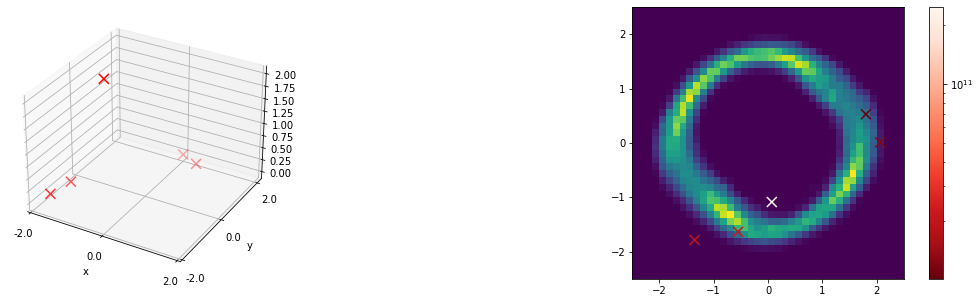

In [309]:
# post, _, scatter, obs0_i, obs0, [y,x,m], _, targets = get_pred(obs0_i = obs0_i)

fig = plt.figure(figsize = (20, 5))
n = 2
ax = fig.add_subplot(1, n, 1, projection='3d')
ax.scatter(*scatter, marker = 'x', color = 'red', s = 100)
tickskip = 4
ax.set_xticks(np.linspace(0, L, 11)[1::tickskip])
ax.set_yticks(np.linspace(0, L, 11)[1::tickskip])
ax.set_xticklabels(np.linspace(-2.5, 2.5, 11)[1::tickskip])
ax.set_yticklabels(np.linspace(-2.5, 2.5, 11)[1::tickskip])
# ax.set_zticks(z)
# ax.set_zticklabels(np.round(np.log10(m_centers.numpy()), 2))
ax.set_xlabel('x')
ax.set_ylabel('y')





ax = fig.add_subplot(1, n, 2)
ax.imshow(obs0['image'].squeeze(), **imkwargs)
im = ax.scatter(x, y, marker = 'x', s = 100, c = m, cmap = 'Reds_r', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar(im, ax = ax)


plt.show()

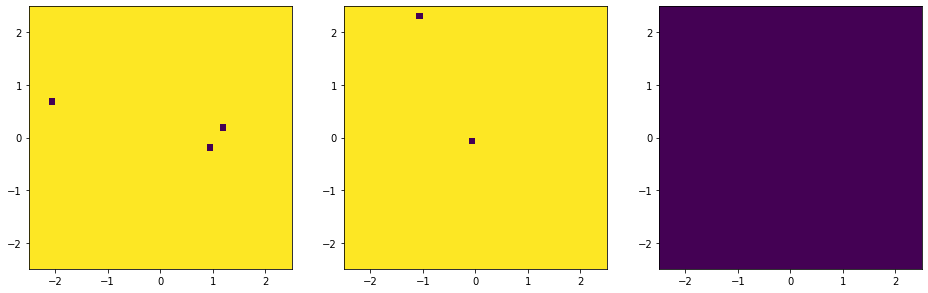

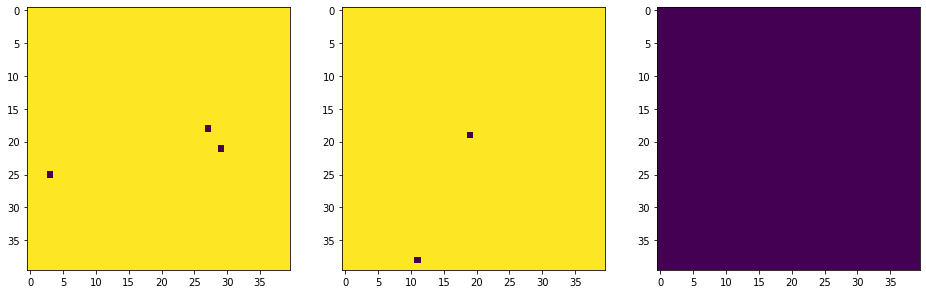

In [263]:
plt_imshow(targets[:nmbins], **imkwargs)
plt_imshow(targets[:nmbins])

i = 24849


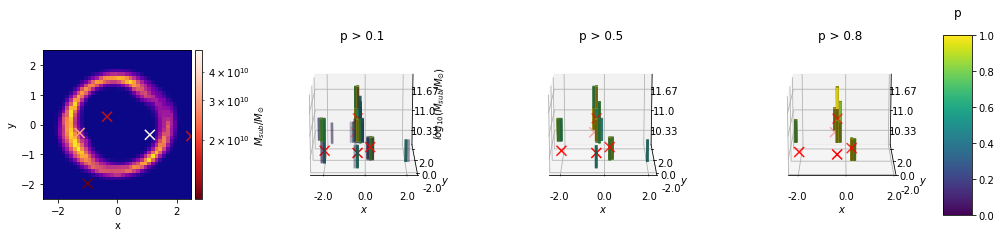

In [235]:
for obs0_i in obs0_is:
    ani, obs0_i = lava_movie(obs0_i = obs0_i, frames = 50, thresholds = [0.1, 0.5, 0.8])

In [236]:
HTML(ani.to_html5_video())